## Import the librairies for the processing


In [1]:
%run librairiesCNN.py

from matplotlib import cm

# Avoid runtimeWarning when no lines are detected
import warnings 
warnings.filterwarnings("ignore")

In [2]:
#load the same window size as for the CNN
file_net = 'networks/network_grayscale_gradient_uniformDisp_n=1M'
h5f = h5py.File(('%s_data.h5' % file_net), 'r')
windowSize = h5f['windowSize'][()]
CNN_width=windowSize
CNN_height=windowSize
overlap=24


## Set parameters for the DNS test


In [3]:
width=1024
height=1024
maxDisplacement=24# in px
particleRadius=range(2,4) #for each particle
gaussianBlurRadius=1
particleDensity=range(2,10) #per image

############################ SAVING DATA ####################################################
#If you want to save the images, set recordImage=True and specify the location and name 
#of the saved files. Make sure the directory DATASETfromDNS exist 
saveImage=False
folder='data/'
imageFile='dataset_JN'

In [4]:
### IN PYTHON X,Y are lines,columns, the DNS must be transposed
fileName='./data/dataSetFromDNS_EPM.hdf5'
f=h5py.File(fileName,'r')

# store data in array
_x00=f[('x')][:]
_y00=f[('y')][:]
u00=f[('u')][:]
v00=f[('v')][:]
# rescaling DNS to the user defined max displacement
u00=u00/u00.max()*maxDisplacement
v00=v00/v00.max()*maxDisplacement

f.close()

originalDisplacement=np.sqrt(u00**2+v00**2)

print('Upload data from {}'.format(fileName))
print('Original Shape of X {}'.format(_x00.shape[0]))
print('Original Shape of Y {}'.format(_y00.shape[0]))
print('Original Shape of U,V {}'.format(u00.shape))

#if the desired image size is different from the original data set, we crop or interpolate
if (_x00.shape[0]!=width) or (_y00.shape[0]!=height):
    resizeImage=True
    _x=np.arange(width)
    _y=np.arange(height)
    u=np.array(skimage.transform.resize(u00, (height, width), anti_aliasing=True))
    v=np.array(skimage.transform.resize(v00, (height, width), anti_aliasing=True))
else:
    resizeImage=False
    _x=_x00
    _y=_y00
    u,v=u00,v00

Upload data from ./data/dataSetFromDNS_EPM.hdf5
Original Shape of X 192
Original Shape of Y 192
Original Shape of U,V (192, 192)


## Calculate the mean displacement, angle and energy spectrum

In [5]:
x,y=np.meshgrid(_x,_y)
displacement=np.sqrt(u**2+v**2)
angle=np.arctan(v/u)*180/np.pi
energy=np.mean(displacement)**2
kx,Ekx,ky,Eky,k,Ek,Ek2D = getEnergySpectrum(_x,_y,displacement-displacement.mean())

originalWidth=_x00.shape[0]
originalheight=_y00.shape[0]
resizedWidth=_x.shape[0]
resizedHeight=_y.shape[0]

print('resizing image')
print('Resized X {}'.format(resizedWidth))
print('Resized Y {}'.format(resizedHeight))
print('Resized U,V {}'.format(u.shape))

xdns,ydns,displacementdns,angledns,W,H=windowAveraging(displacement,angle,CNN_width,CNN_height,overlap)

resizing image
Resized X 1024
Resized Y 1024
Resized U,V (1024, 1024)


Plot DNS and its statistics

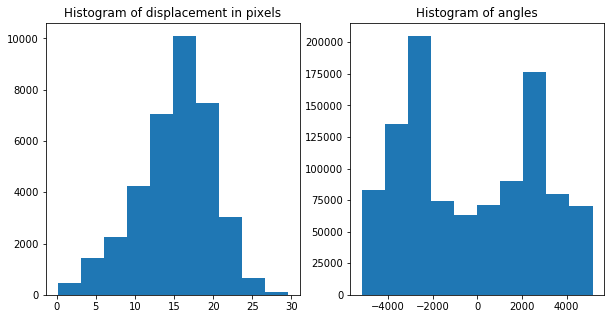

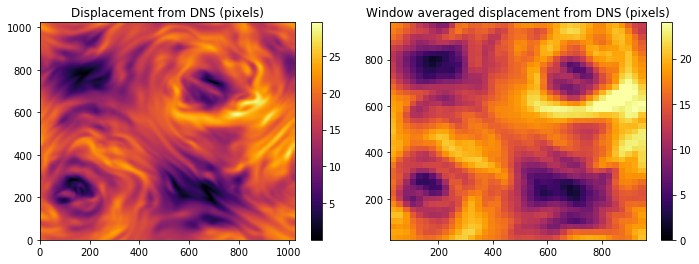

In [6]:
fig = figure(figsize=(10,5))
fig.add_subplot(1,2,1)
title('Histogram of displacement in pixels')
hist(originalDisplacement.flatten())   
fig.add_subplot(1,2,2)
title('Histogram of angles')
hist(angle.flatten()*180/np.pi)
show()

fig = figure(figsize=(12,4))
fig.add_subplot(1,2,1)
title('Displacement from DNS (pixels)')
p = pcolormesh(x,y,displacement,cmap='inferno')
colorbar(p)
fig.add_subplot(1,2,2)
title('Window averaged displacement from DNS (pixels)')
pmean = pcolormesh(xdns,ydns,displacementdns,vmin=0,vmax=maxDisplacement,cmap='inferno')
colorbar(pmean)

subplots_adjust(hspace=0.35, wspace = 0.1)
savefig('paper/figs/figure5.png', dpi=300, format='png', bbox_inches='tight', pad_inches=0)
show()

## Generate streak images from DNS

Finished, took 1.2047s. 1.66 images/sec.


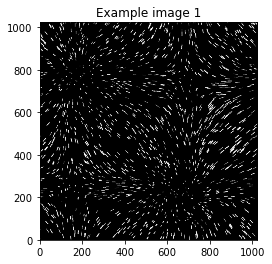

In [7]:
# Generate count images
nImages = 2
start_time = time.time()
myImagesGenerator = DNS_StreakImageGenerator(x,y,u,v,particleDensity,particleRadius,CNN_width,CNN_height)
myImages= myImagesGenerator.generate(count = nImages, sigma = 1, truncate = 2)
elapsed_time = time.time() - start_time
print("Finished, took {:.4f}s. {:.2f} images/sec.".format(elapsed_time, \
        nImages / elapsed_time))
     
# Plot one of images
iImage = 1
figure()
title('Example image %d' % iImage)
gray()
imshow(myImages[iImage,0,:,:], origin='lower')

im = Image.fromarray(myImages[iImage,0,:,:])

# Save images in an HDF5 file
if saveImage:
    fileName = folder + imageFile + '.hdf5'
    h = h5py.File(fileName,'w')
    h.create_dataset('x',data=x)
    h.create_dataset('y',data=y)
    h.create_dataset('u',data=u)
    h.create_dataset('v',data=v)
    h.create_dataset('images',data=myImages)
    h.close()

## Apply Hough Tranform to 48x48 pixels sub-windows with 24px overlap

In [8]:
start_time=time.time()

_xcnnConcatenated,_ycnnConcatenated,splittedImages,nh,nw =\
splitWindows(myImages,CNN_width,CNN_height,overlap)

iImage=1

Delta_residuals=[]
Angle_residuals=[]
predictionDelta=[]
predictionAngle=[]
rmsDelta=[]
rmsAngle=[]

DeltaDNS=np.concatenate(displacementdns)
AngleDNS=np.concatenate(angledns)

displacementHough=np.zeros((nh,nw))
angleHough=np.zeros((nh,nw))


numberEmptyLines=0
imagesTOprocess = splittedImages[iImage,:,:,:,:]
for i in range(imagesTOprocess.shape[0]):
    lines,displacements,angles,Delta,Angle,rmsD,rmsA=probHoughTransform(\
             imagesTOprocess[i,0,:,:],\
             threshold=15, \
             line_length=4,\
             line_gap=5)      

    if len(lines)==0:
        numberEmptyLines+=1
        predictionDelta.append(np.nan)
        predictionAngle.append(np.nan)
        rmsDelta.append(np.nan)
        rmsAngle.append(np.nan)
        Delta_residuals.append(np.nan)
        Angle_residuals.append(np.nan)
    else:    
        predictionDelta.append(Delta)
        predictionAngle.append(Angle)
        rmsDelta.append(rmsD)
        rmsAngle.append(rmsA)
        Delta_residuals.append(Delta-DeltaDNS[i])
        Angle_residuals.append(Angle-AngleDNS[i])
    
predictionDelta=np.array(predictionDelta)
predictionDelta_NoNan= predictionDelta[~np.isnan(predictionDelta)]

predictionAngle=np.array(predictionAngle)
predictionAngle_NoNan= predictionAngle[~np.isnan(predictionAngle)]

rmsDelta=np.array(rmsDelta)
rmsDelta_NoNan= rmsDelta[~np.isnan(rmsDelta)]

rmsAngle=np.array(rmsAngle)
rmsAngle_NoNan= rmsAngle[~np.isnan(rmsAngle)]

Delta_residuals=np.array(Delta_residuals)
Delta_residuals_NoNan= Delta_residuals[~np.isnan(Delta_residuals)]

Angle_residuals=np.array(Angle_residuals)
Angle_residuals_NoNan= Angle_residuals[~np.isnan(Angle_residuals)]

displacementHough[:,:] = np.reshape(predictionDelta, (nh,nw))
angleHough[:,:] = np.reshape(predictionAngle, (nh,nw))
xcnn = np.reshape(np.array(_xcnnConcatenated), (nh,nw))
ycnn = np.reshape(np.array(_ycnnConcatenated), (nh,nw))
_xcnn = xcnn[:,0]
_ycnn = ycnn[0,:]

elapsed_time = time.time() - start_time
print("Testing finished, took {:.4f}s. {:.2f} images/sec.".format(elapsed_time, \
                            1 / elapsed_time))

Testing finished, took 3.4140s. 0.29 images/sec.


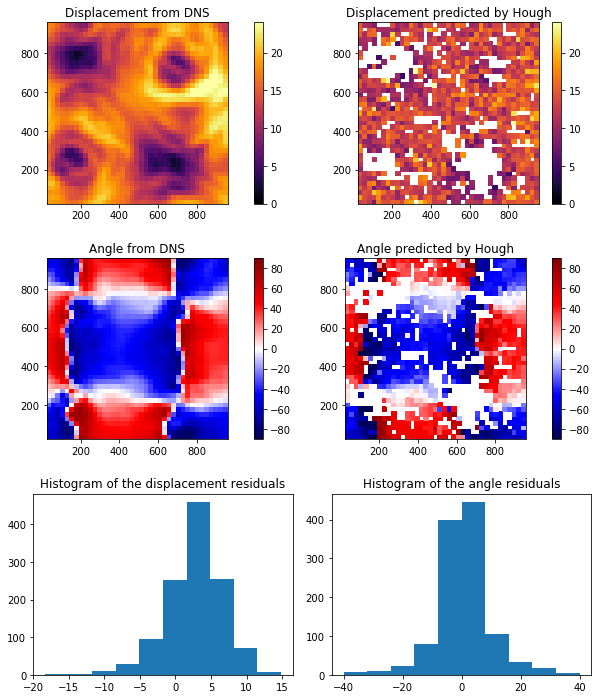

In [9]:
errorDisplacement=[]
errorAngle=[]

errorDisplacement.append(displacementdns - displacementHough)
errorAngle.append(angledns - angleHough)

figure(figsize=(10,12))
subplot(3,2,1)
title('Displacement from DNS')
pdispdns=pcolormesh(xdns,ydns,displacementdns,vmin=0,vmax=maxDisplacement,cmap='inferno')
colorbar(pdispdns)
axis('scaled')
subplot(3,2,2)

title('Displacement predicted by Hough')
pdispcnn=pcolormesh(xdns,ydns,displacementHough,vmin=0,vmax=maxDisplacement,cmap='inferno')
axis('scaled')
colorbar(pdispcnn)

subplot(3,2,3)
title('Angle from DNS')
pangdns=pcolormesh(xdns,ydns,angledns,vmin=-90,vmax=90, cmap='seismic')
colorbar(pangdns)
axis('scaled')

subplot(3,2,4)
title('Angle predicted by Hough')
panglecnn=pcolormesh(xdns,ydns,angleHough,vmin=-90,vmax=90, cmap='seismic')
colorbar(panglecnn)
axis('scaled')

subplot(3,2,5)
title('Histogram of the displacement residuals')
h1=hist(np.array(errorDisplacement).flatten(), density=False)

subplot(3,2,6)
title('Histogram of the angle residuals')
h2=hist(np.array(errorAngle).flatten(), range=(-40,40),density=False)

subplots_adjust(hspace=0.3, wspace = 0.15)
#savefig('paper/figs/HoughAppliedToDNS.png', dpi=300, format='png', bbox_inches='tight', pad_inches=0)

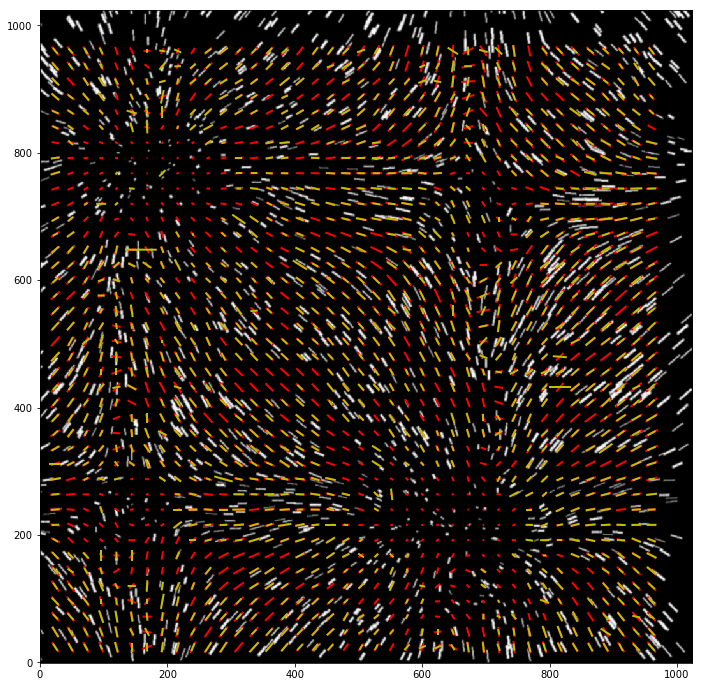

In [10]:
#select an image to compare the results to 
plotdns=True
plotcnn=True
showimage=True

fig=figure(figsize=(12,12))
ax = fig.add_subplot(1,1,1)
if showimage==True:
    imshow((myImages[iImage,0,:,:]), origin='lower')

# Streaks from DNS
if plotdns==True:
    xminus = xdns.flatten() - np.cos( angledns.flatten() * np.pi / 180) \
    * displacementdns.flatten() / 2.
    xplus = xdns.flatten() + np.cos( angledns.flatten() * np.pi / 180) \
    * displacementdns.flatten() / 2.

    yminus = ydns.flatten() - np.sin( angledns.flatten() * np.pi / 180) \
    * displacementdns.flatten() / 2.
    yplus = ydns.flatten() + np.sin( angledns.flatten() * np.pi / 180) \
    * displacementdns.flatten() / 2.

    xydns = np.array(([xminus, yminus], [xplus, yplus]));

    for i in range(0,xydns.shape[2]):
        linedns = patches.Polygon(xydns[:,:,i], color = 'r', linewidth = 2)
        ax.add_patch(linedns)
    
# Streaks from CNN
if plotcnn==True:
    x0 = xcnn.flatten() - np.cos( angleHough.flatten() * np.pi / 180) \
    * displacementHough.flatten() / 2.
    x1 = xcnn.flatten() + np.cos( angleHough.flatten() * np.pi / 180) \
    * displacementHough.flatten() / 2.

    y0 = ycnn.flatten() - np.sin( angleHough.flatten() * np.pi / 180) \
    * displacementHough.flatten() / 2.
    y1 = ycnn.flatten() + np.sin( angleHough.flatten() * np.pi / 180) \
    * displacementHough.flatten() / 2.

    xycnn = np.array(([x0, y0], [x1, y1]));

    for i in range(0,xycnn.shape[2]):
        line = patches.Polygon(xycnn[:,:,i], color = 'y', linewidth = 2)
        ax.add_patch(line)

savefig('paper/figs/StreaksRebuildFromHough.png', dpi=300, format='png', bbox_inches='tight', pad_inches=0)
show()